# Выбор локации для скважины. Описание проекта.

Вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.  
Шаги для выбора локации обычно такие:  
    •	В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;  
    •	Строят модель для предсказания объёма запасов в новых скважинах;  
    •	Выбирают скважины с самыми высокими оценками значений;  
    •	Определяют регион с максимальной суммарной прибылью отобранных скважин.  
Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.


## Описание данных.

  •	id — уникальный идентификатор скважины;  
  •	f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);  
  •	product — объём запасов в скважине (тыс. баррелей).  

## Условия задачи:

  •	Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые). 
  •	При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.  
  •	Бюджет на разработку скважин в регионе — 10 млрд рублей.  
  •	При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс.  рублей, поскольку объём указан в тысячах баррелей.  
  •	После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.    

# 1. Загрузка и подготовка данных.

In [1]:
#Импорт библиотек
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

from IPython.display import display
from scipy import stats as st
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.utils import shuffle

In [2]:
import os

pth1_0 = 'D:/YANDEX.PRAKTIKUM/DATA_SCIENCE/Машинное_обучение_в_бизнесе/geo_data_0.csv'
pth1_1 = 'D:/YANDEX.PRAKTIKUM/DATA_SCIENCE/Машинное_обучение_в_бизнесе/geo_data_1.csv'
pth1_2 = 'D:/YANDEX.PRAKTIKUM/DATA_SCIENCE/Машинное_обучение_в_бизнесе/geo_data_2.csv'
pth2_0 = '/datasets/geo_data_0.csv'
pth2_1 = '/datasets/geo_data_1.csv'
pth2_2 = '/datasets/geo_data_2.csv'

if (os.path.exists(pth1_0) and os.path.exists(pth1_1) and os.path.exists(pth1_2)):
    df_geo_data_0 = pd.read_csv(pth1_0)
    df_geo_data_1 = pd.read_csv(pth1_1)
    df_geo_data_2 = pd.read_csv(pth1_2)
elif (os.path.exists(pth2_0) and os.path.exists(pth2_1) and os.path.exists(pth2_2)):
    df_geo_data_0 = pd.read_csv(pth2_0)
    df_geo_data_1 = pd.read_csv(pth2_1)
    df_geo_data_2 = pd.read_csv(pth2_2)
else:
    print('Something is wrong')
    
df_geo_data_0.name = 'geo_data_0'   
df_geo_data_1.name = 'geo_data_1'
df_geo_data_2.name = 'geo_data_2'    

Посмотрим на первые 2 строки и сводную информацию для каждого датафрейма.

In [3]:
dataframes = [df_geo_data_0, df_geo_data_1, df_geo_data_2]
for df in dataframes:
    print('СВОДНАЯ ИНФОРМАЦИЯ ПО ДАТАФРЕЙМУ ' + df.name)
    display(df.info())
    display(df.head(2))
    print('Кол-во строк: {}\nКол-во столбцов: {}'.format(df.shape[0], df.shape[1]))
    print('\n')

СВОДНАЯ ИНФОРМАЦИЯ ПО ДАТАФРЕЙМУ geo_data_0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.22117,105.280062
1,2acmU,1.334711,-0.340164,4.36508,73.037750


Кол-во строк: 100000
Кол-во столбцов: 5


СВОДНАЯ ИНФОРМАЦИЯ ПО ДАТАФРЕЙМУ geo_data_1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261


Кол-во строк: 100000
Кол-во столбцов: 5


СВОДНАЯ ИНФОРМАЦИЯ ПО ДАТАФРЕЙМУ geo_data_2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697


Кол-во строк: 100000
Кол-во столбцов: 5




#### Результат
Все столбцы датафреймов имеют корректные типы данных (object и float64), а также не содержат пропусков.

Проверим датафреймы на наличие дублей. Будем считать, что строчки задублированы, если у них повторяются значния в столбце id. Посчитаем кол-во дублей в каждом датафрейме.

In [4]:
for df in dataframes:
    print('Кол-во дублей в датафрейме "{}": {}'.format(df.name, df[df.duplicated('id', keep=False)].shape[0]))

Кол-во дублей в датафрейме "geo_data_0": 20
Кол-во дублей в датафрейме "geo_data_1": 8
Кол-во дублей в датафрейме "geo_data_2": 8


#### Результат
Количество дублей не существенно.

Удалим дубликаты из датафреймов и проверим результат.

In [5]:
for df in dataframes:
    name = df.name
    df = df.drop_duplicates(subset='id', keep=False).reset_index(drop=True)
    df.name = name
    print('Кол-во дублей в датафрейме "{}" после удаления: {}'.format(df.name, df[df.duplicated('id', keep=False)].shape[0]))

Кол-во дублей в датафрейме "geo_data_0" после удаления: 0
Кол-во дублей в датафрейме "geo_data_1" после удаления: 0
Кол-во дублей в датафрейме "geo_data_2" после удаления: 0


Столбец id является категориальным с большим количеством уникальных значений, что не позволяет заменить его с помощью метода One-Hot Encoding. Также невозможно заменить данный категориальный столбец на количественный с помощью метода Ordinal Encoding, т.к. в дальнейшем по условию задачи данные будут обучаться линейной регрессией. По этим причинам удалим столбей id из датасетов.

In [6]:
for df in dataframes:
    df.drop('id', axis=1, inplace=True)

Посмотрим распределения признаков f0, f1, f2 у датафреймов.

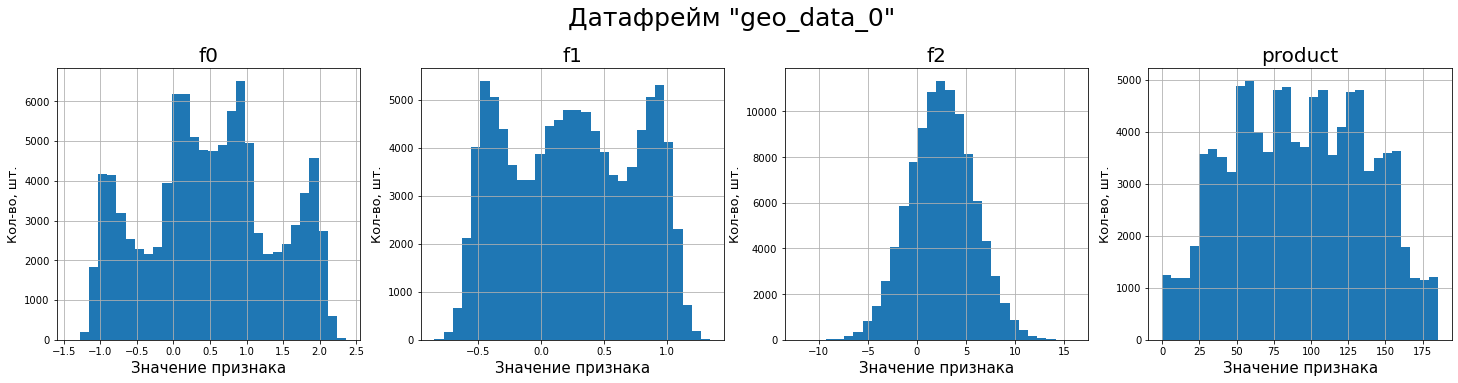

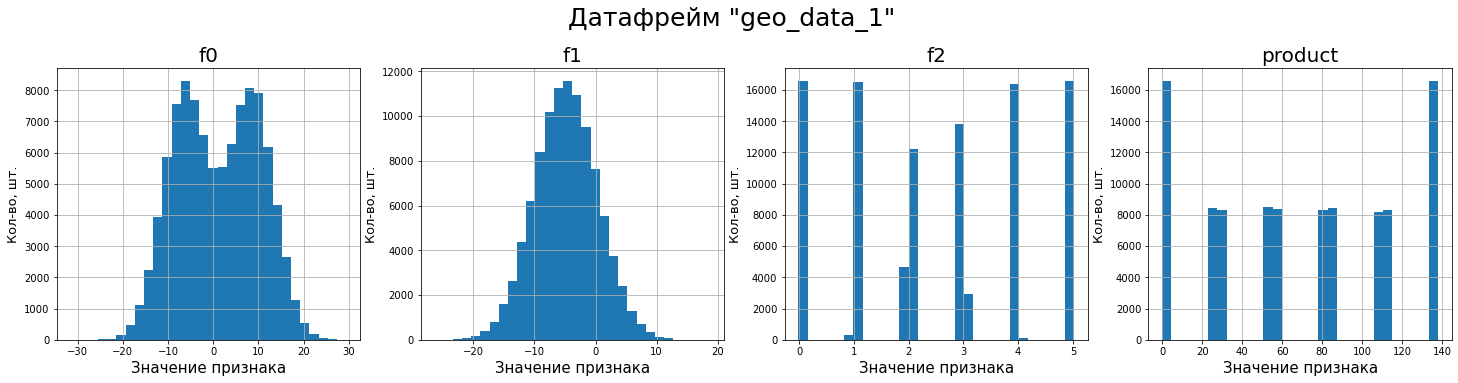

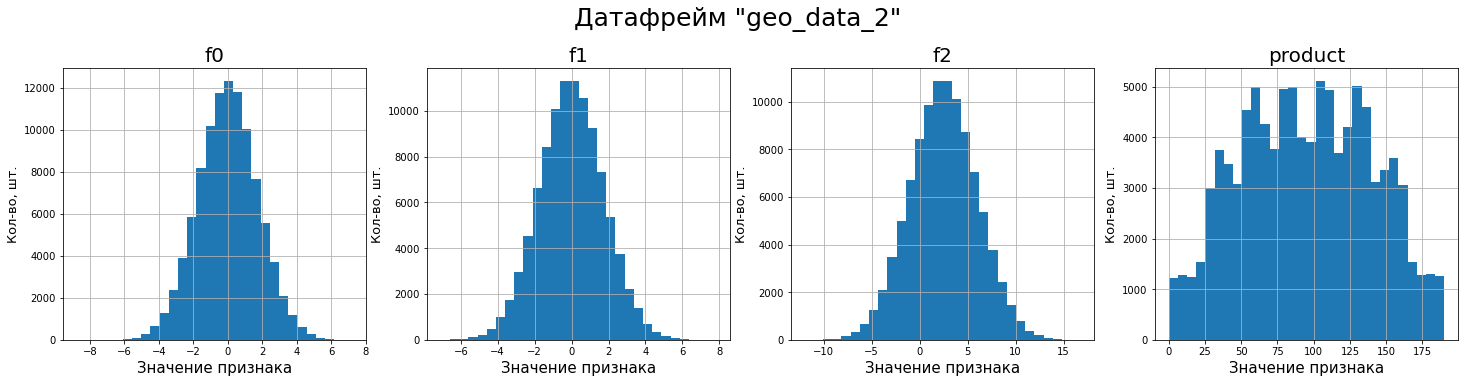

In [7]:
for df in dataframes:
    fig = plt.figure(figsize=(25, 5))
    ttl = fig.suptitle('Датафрейм "{}"'.format(df.name), fontsize=25)
    ttl.set_position([.5, 1.05])
    
    rows = 1
    cols = 4
    counter = 1
    for column in ['f0', 'f1', 'f2', 'product']:
        ax = plt.subplot(rows, cols, counter)
        plt.xlabel('Значение признака', fontsize=15)
        plt.ylabel('Кол-во, шт.', fontsize=13)
        ax.set_title(column, fontsize=20)
        df[column].hist(bins=30)
        counter += 1
    print('\n')
    plt.show()

#### Результат
У датафреймов geo_data_0 и geo_data_1 столбцы f0 и f1 имееют несколько вершин в своих распределениях. Возможно, эти признаки состоят из двух или нескольких признаков. Однако, не имея подробную информацию о данных столбцах, попытаться разложить данные признаки на несколько не представляется возможным.

Данные имеют разный масштаб, поэтому необходимо их масштабировать. Масштабирование возможно после разбиения данных на обучающую и валидационную выборки. Поэтому масштабирование будет сделано после разбиения на обучающую и валидационные выборки.

### Вывод
Была проведена предобработка данных:

    - удалены все дубли из датафреймов;  
    - установлено, что данные не содержат пропуски;  
    - удален столбец id из-за невозможности преобразования в количественный признак;   
    - исследован масштаб количественных данных, принято решение о масштабировании количественных данных в после разбиения датасетов на обучающую и валидационную выборки.   

# 2. Обучение и проверка модели.

Разделим у каждого датафрейма имеющиеся данные на две выборки: обучающую и валидационную в соотношении 75% : 25%, соответственно.

In [8]:
#Создадим словарь 'features', в котором ключ - это имя датафрейма, а значение - набор признаков соответствующего датафрейма
features = {}
for df in dataframes:
    features[df.name] = df.drop('product', axis=1)

#Создадим словарь 'target', в котором ключ - это имя датафрейма, а значение - набор целевого признака соответствующего датафрейма
target = {}
for df in dataframes:
    target[df.name] = df['product']

#Создадим словари для обучающих и валидационных выборок для всех датафреймов
features_train = {}
features_valid = {}
target_train = {}
target_valid = {}

for df in dataframes:
    features_train[df.name], features_valid[df.name], target_train[df.name], target_valid[df.name] = train_test_split(
        features[df.name], target[df.name], test_size=0.25, random_state=12345, shuffle=True)

Проверим соотношения выборок у каждого датафрейма.

In [9]:
for df in dataframes:
    train_size = len(target_train[df.name]) / len(target[df.name])
    valid_size = len(target_valid[df.name]) / len(target[df.name])

    print('Доля обучающей выборки датафрейма "{}": {:.0%}'.format(df.name, train_size))
    print('Доля валидационной выборки датафрейма "{}": {:.0%}'.format(df.name, valid_size))
    print('\n')

Доля обучающей выборки датафрейма "geo_data_0": 75%
Доля валидационной выборки датафрейма "geo_data_0": 25%


Доля обучающей выборки датафрейма "geo_data_1": 75%
Доля валидационной выборки датафрейма "geo_data_1": 25%


Доля обучающей выборки датафрейма "geo_data_2": 75%
Доля валидационной выборки датафрейма "geo_data_2": 25%




#### Результат
Выборки всех датафреймов имеют корректные соотношения.

Как было указано ранее, проведем масштабирование количественных признаков у всех датафреймов.

In [10]:
columns = ['f0', 'f1', 'f2']
for df in dataframes:
    scaler = StandardScaler()
    scaler.fit(features_train[df.name])
    
    features_train[df.name][columns] = scaler.transform(features_train[df.name][columns])
    features_valid[df.name][columns] = scaler.transform(features_valid[df.name][columns])

Проверим результат масштабирования.

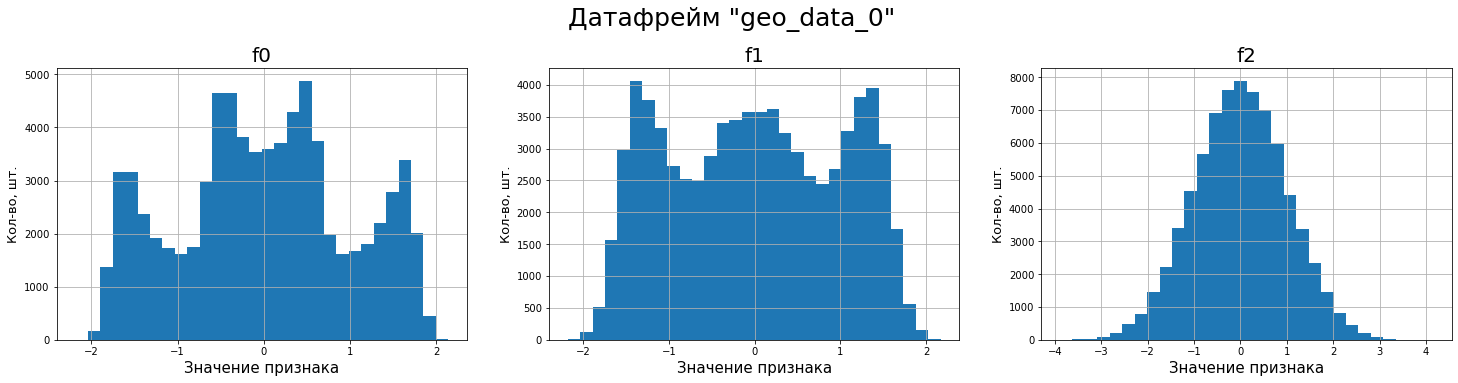

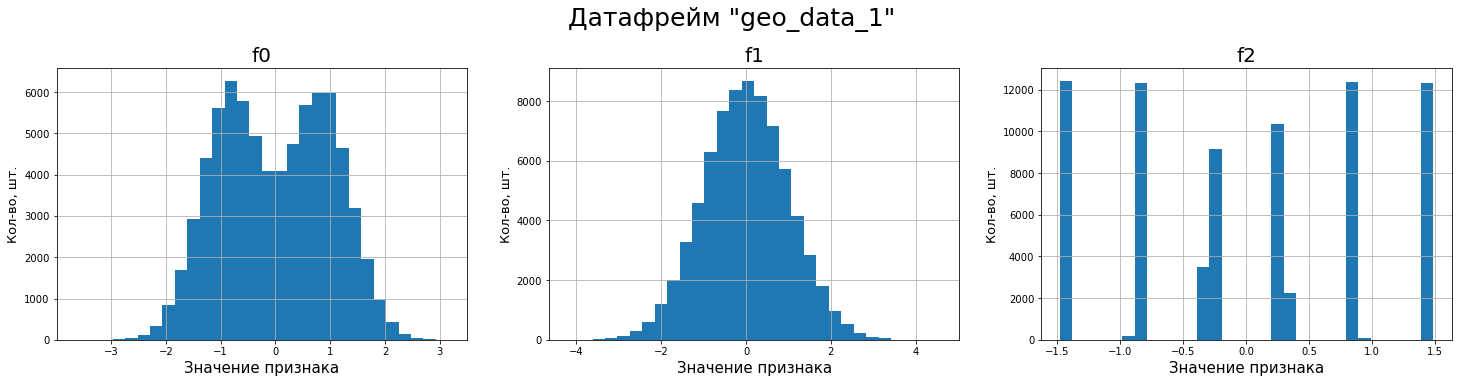

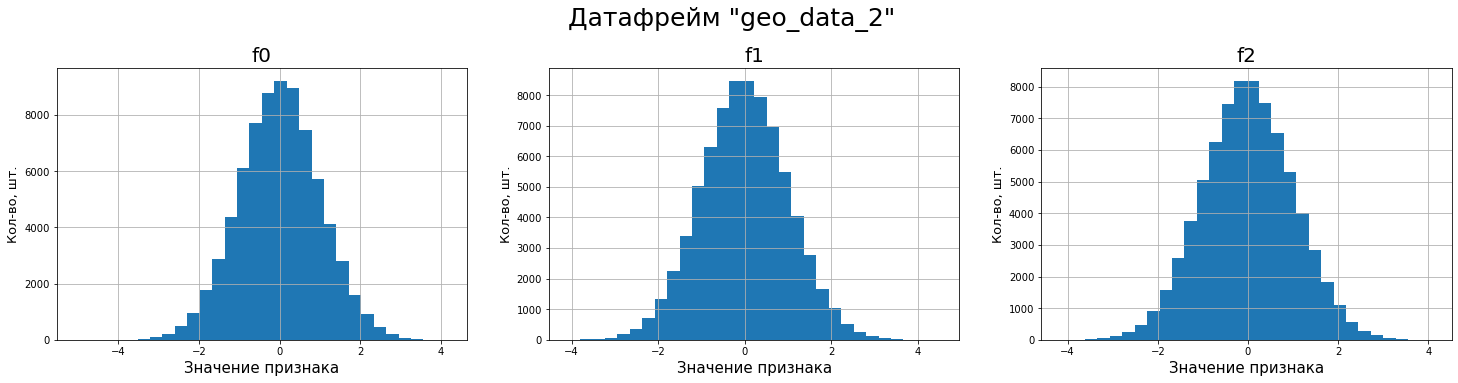

In [11]:
for df in dataframes:
    fig = plt.figure(figsize=(25, 5))
    ttl = fig.suptitle('Датафрейм "{}"'.format(df.name), fontsize=25)
    ttl.set_position([.5, 1.05])
    
    rows = 1
    cols = 3
    counter = 1
    for column in ['f0', 'f1', 'f2']:
        ax = plt.subplot(rows, cols, counter)
        plt.xlabel('Значение признака', fontsize=15)
        plt.ylabel('Кол-во, шт.', fontsize=13)
        ax.set_title(column, fontsize=20)
        features_train[df.name][column].hist(bins=30)
        counter += 1
    print('\n')
    plt.show()

Все количественные признаки у датафреймов распределены вокруг значения 0.

Далее обучим модели с помощью линейной регресии.

In [12]:
# Словари для хранения предсказаний/таргетов/признаков (значение словаря) по соответствующему датафрейму (ключ словаря)
predicted_valid = {}
predicted_valid_top200 = {}
target_valid_top200 = {}
features_valid_top200 = {}
model = {}

for df in dataframes:
    model[df.name] = LinearRegression()
    model[df.name].fit(features_train[df.name], target_train[df.name])
    predicted_valid[df.name] = pd.Series(data=model[df.name].predict(features_valid[df.name]),
                                         index=features_valid[df.name].index)
    
    #Отбираем 200 самых продуктивных скважин в каждом регионе
    predicted_valid_top200[df.name] = predicted_valid[df.name].sort_values(ascending=False).head(200)
    selected_indexes = predicted_valid_top200[df.name].index
    target_valid_top200[df.name] = target_valid[df.name].loc[selected_indexes]
    
    predicted_valid_top200_mean = predicted_valid_top200[df.name].mean()
    rmse_top200 = mean_squared_error(target_valid_top200[df.name], predicted_valid_top200[df.name]) ** 0.5
    r2 = r2_score(target_valid[df.name], predicted_valid[df.name])
    
    print('                             Регион "{}"'.format(df.name))
    print('Средний запас предсказанного сырья для топ-200 скважин:           {:.4f} тыс.'.
          format(predicted_valid_top200_mean))
    print('RMSE для топ-200 скважин:                                         {:.4f} тыс.'.
          format(rmse_top200))
    print('Коэффициент детерминации R2 (по всей валидационной выборке):      {:.2%}'.
          format(r2)) 
    print('\n')

                             Регион "geo_data_0"
Средний запас предсказанного сырья для топ-200 скважин:           155.5117 тыс.
RMSE для топ-200 скважин:                                         27.2948 тыс.
Коэффициент детерминации R2 (по всей валидационной выборке):      27.99%


                             Регион "geo_data_1"
Средний запас предсказанного сырья для топ-200 скважин:           138.7301 тыс.
RMSE для топ-200 скважин:                                         0.8345 тыс.
Коэффициент детерминации R2 (по всей валидационной выборке):      99.96%


                             Регион "geo_data_2"
Средний запас предсказанного сырья для топ-200 скважин:           148.0195 тыс.
RMSE для топ-200 скважин:                                         29.4471 тыс.
Коэффициент детерминации R2 (по всей валидационной выборке):      20.52%




### Вывод
Можно сделать вывод, что модели, обученные на датасетах geo_data_0 и geo_data_2, имеют слабую предсказательную способность, о чем свидетельствует низкое значение коэффициента детерминации (R2 = 27,99%, 20,52%).  

Наименьшее количество среднего предсказанного сырья у региона geo_data_1. Но при этом этим модель, обученная на данных из этого региона, имеет наибольший коэффициент детерминации (R2 = 99.96%).

# 3. Подготовка к расчету прибыли.

Сохраним все ключевые значения для расчётов в отдельных переменных.

In [13]:
number_of_points = 500 # Кол-во точек, исследуемых при разведке региона
ml_number_of_points = 200 # Кол-во лучших точек, отбираемых с помощью машинного обучения для разработки
total_costs = 10000000000 # Бюджет на разработку скважин в одном регионе 10 млрд. рублей
revenue_per_oil_well = 450000 # Доход с каждой единицы продукта составляет 450 тыс. рублей
loss_probability = 0.025 # Вероятность убытков меньше 2,5%

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.

In [14]:
loss_per_oil_well = total_costs / ml_number_of_points #Делим весь бюджет на кол-во разведываемых скважин
necessary_product = loss_per_oil_well / revenue_per_oil_well
print('Необходимый объём сырья на одну скважину для безубыточной разработки новой скважины: {:.2f} тыс. баррелей'.
      format(necessary_product))

Необходимый объём сырья на одну скважину для безубыточной разработки новой скважины: 111.11 тыс. баррелей


Напишим функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.

In [15]:
def total_profit(data, region):
    features = data.drop('product', axis=1)
    targets = data['product']
    predictions = model[region].predict(features)
    predictions = pd.Series(predictions, index=features.index)
    selected_oil_well = predictions.sort_values(ascending=False).head(200).index
    revenue = targets.loc[selected_oil_well].sum() * revenue_per_oil_well
    costs = total_costs
    profit = revenue - costs
    return profit

### Вывод
Среднее количество предсказанного сырья во всех трех регионах ( 155.51 тыс.барр., 138.73 тыс.барр., 148.01 тыс. барр.) выше необходимого объема для безубыточной разработки новой скважины (111.11 тыс. барр.) Наиболее высокое значение среднего объема сырья у региона geo_data_0.

# 4. Расчет прибыли и рисков.

Посчитаем риски и прибыль для каждого региона. Найдем распределение прибыли с помощью техники Bootstrap.

In [16]:
state = np.random.RandomState(12345)
bootstrap_samples = 1000

values = {}
for df in dataframes:
    values[df.name] = []

for df in dataframes:
    for i in range(bootstrap_samples):
        subsample = df.sample(n=500, replace=False, random_state=state)
        values[df.name].append(total_profit(data=subsample, region=df.name))
    values[df.name] = pd.Series(values[df.name])

Изучим распределение прибыли по каждому региону.

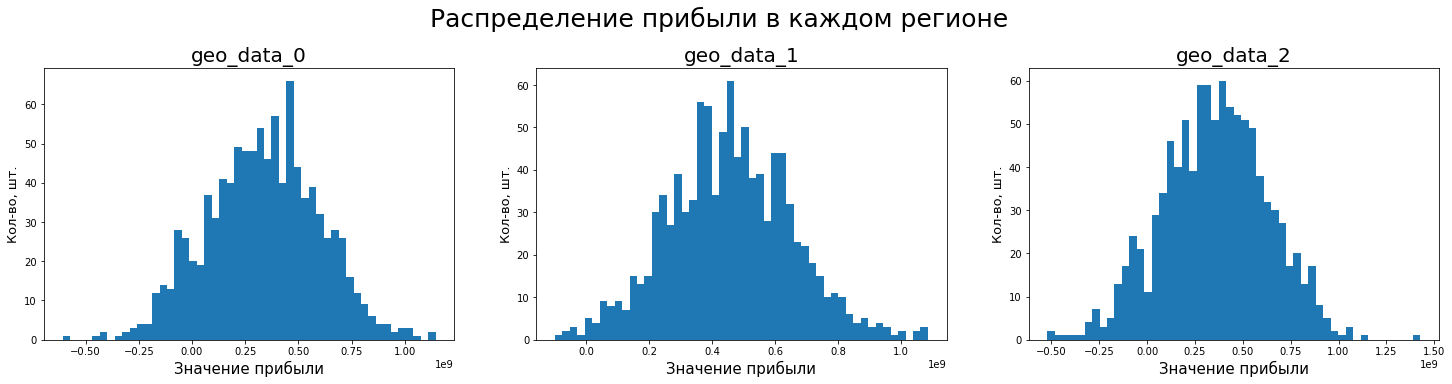

In [17]:
fig = plt.figure(figsize=(25, 5))
ttl = fig.suptitle('Распределение прибыли в каждом регионе', fontsize=25)
ttl.set_position([.5, 1.05])

rows = 1
cols = 3
counter = 1
for df in dataframes:
    ax = plt.subplot(rows, cols, counter)
    plt.xlabel('Значение прибыли', fontsize=15)
    plt.ylabel('Кол-во, шт.', fontsize=13)
    ax.set_title(df.name, fontsize=20)
    plt.hist(values[df.name], density=False, bins=50)
    counter += 1
plt.show()

Рассчитаем размер средней прибыль для каждого региона.

In [18]:
for df in dataframes:
    profit_mean = values[df.name].mean() / 1000000 #прибыль в миллионах
    print('Средняя прибыль в регионе "{}": {:.2f} млн. руб.'.format(df.name, profit_mean))

Средняя прибыль в регионе "geo_data_0": 334.90 млн. руб.
Средняя прибыль в регионе "geo_data_1": 457.30 млн. руб.
Средняя прибыль в регионе "geo_data_2": 355.97 млн. руб.


Найдем 95%-й доверительный интервал, в котором находится средняя прибыль от разработки региона.

In [19]:
for df in dataframes:
    lower = values[df.name].quantile(0.025) / 1000000
    upper = values[df.name].quantile(0.975) / 1000000
    print('Доверительный интервал для средней прибыли в регионе "{}": [{:.2f}, {:.2f}] (млрд. руб.)'.
          format(df.name, lower, upper))

Доверительный интервал для средней прибыли в регионе "geo_data_0": [-163.15, 829.37] (млрд. руб.)
Доверительный интервал для средней прибыли в регионе "geo_data_1": [67.19, 858.06] (млрд. руб.)
Доверительный интервал для средней прибыли в регионе "geo_data_2": [-167.11, 871.55] (млрд. руб.)


Значение средней прибыли в регионе geo_data_0 и geo_data_2 очень сильно разбросаны, что делает их генеральные средние значения прибыли мало информативными. Также в указанных регионах есть существенный риск зафиксировать убыток.

Рассчиттаем вероятность зафиксировать убыток в каждом регионе.

In [21]:
for df in dataframes:
    count_loss = len(values[df.name][values[df.name] < 0])
    loss_prob = count_loss / bootstrap_samples
    print('Вероятность зафиксировать убыток в регионе "{}": {:.2%}'.format(df.name, loss_prob))

Вероятность зафиксировать убыток в регионе "geo_data_0": 11.90%
Вероятность зафиксировать убыток в регионе "geo_data_1": 1.00%
Вероятность зафиксировать убыток в регионе "geo_data_2": 10.60%





### Вывод
В соответствии с условиями проекта после оценки рисков необходимо оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Указанному условию удовлетворяет лишь один регион - geo_data_1.

Таким образом для разработки месторождения может быть предложен единственный geo_data_1, в качестве  региона с самой низкой из рассчитанных вероятностью убытков и наибольшей из рассчитанных размером средней прибыли от разработки. В для оценки возможности разработки местророждений в других регионах необходима дополнительная информация. 